In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from math import floor
import yfinance as yf

In [10]:
def get_historic_data(symbol1):
    stock = yf.download(symbol1, start="2017-01-01", end="2023-01-01")
    return stock

In [11]:
def vwap(close_prices, volumes):
    vwap_value = []
    if len(close_prices) != len(volumes):
        raise ValueError("The length of close_prices and volumes must be the same.")

    total_price_volume = 0.0
    total_volume = 0.0
    # taking into consideration only the 3 days
    for i in range(2, len(close_prices)):
        total_price_volume = 0.0
        total_volume = 0.0
        total_price_volume += (close_prices[i] * volumes[i]) + (close_prices[i - 1] * volumes[i - 1]) + (
                    close_prices[i - 2] * volumes[i - 2])
        total_volume += volumes[i] + volumes[i - 1] + volumes[i - 2]
        vwap_value.append(total_price_volume / total_volume)
    # vwap elements=total_elements-2
    if total_volume == 0:
        raise ValueError("Total volume is zero. Cannot calculate VWAP.")

    # vwap_value = total_price_volume / total_volume
    return vwap_value


In [14]:
def backtest(strategy, stock_data, initial_balance):
    balance = initial_balance
    position = 0
    portfolio_value = []
    buy_points = []
    sell_points = []
    for i in range(len(strategy)):
        vwap_value = strategy[i]
        current_price = stock_data[i]

        # Buy condition: VWAP is greater than current price
        if vwap_value > current_price and balance > current_price:
            shares_to_buy = floor(balance / current_price)
            position += shares_to_buy
            balance -= shares_to_buy * current_price
            buy_points.append(i)

        # Sell condition: VWAP is less than current price and we have shares
        elif vwap_value < current_price and position > 0:
            balance += position * current_price
            position = 0
            sell_points.append(i)

        # Calculate portfolio value
        portfolio_value.append(balance + position * current_price)

    return portfolio_value, buy_points, sell_points


stock_name = input("Enter stock name: ")
stock_data = get_historic_data(stock_name)
stock_Close = stock_data.loc[:, ["Close"]].to_numpy()
stock_Volume = stock_data.loc[:, ["Volume"]].to_numpy()

vwap_values = np.array(vwap(stock_Close, stock_Volume))

# Backtest with 1,000,000 Rs initial balance
initial_balance = 1000000
portfolio_value, buy_points, sell_points = backtest(vwap_values, stock_Close.flatten(), initial_balance)

# Calculate metrics
total_trades = len(buy_points)
win_trades = sum(portfolio_value[i] > portfolio_value[i - 1] for i in sell_points)
loss_trades = total_trades - win_trades

win_percentage = (win_trades / total_trades) * 100
loss_percentage = (loss_trades / total_trades) * 100

returns = (portfolio_value[-1] / initial_balance) ** (1 / (len(portfolio_value) / 252)) - 1

# Calculate Maximum Drawdown
max_drawdown = 0
peak = portfolio_value[0]
for value in portfolio_value:
    if value > peak:
        peak = value
    else:
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown

Enter stock name: aapl
[*********************100%***********************]  1 of 1 completed


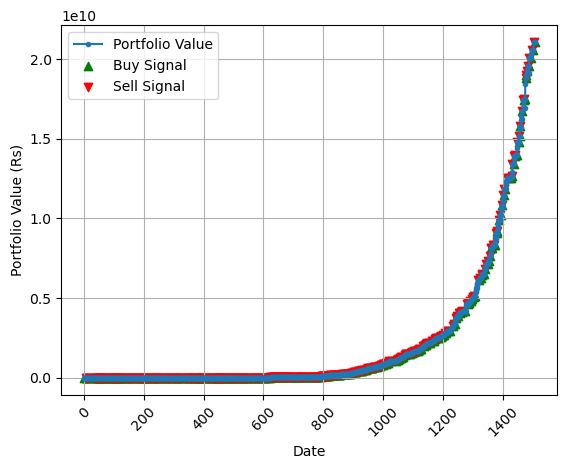

In [15]:
# Plotting
plt.plot(portfolio_value, label='Portfolio Value', marker='.')
plt.scatter(buy_points, [portfolio_value[i] for i in buy_points], marker='^', color='g', label='Buy Signal')
plt.scatter(sell_points, [portfolio_value[i] for i in sell_points], marker='v', color='r', label='Sell Signal')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Rs)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def calculate_metrics(portfolio_value, buy_points, sell_points, initial_balance):
    total_trades = len(buy_points)
    win_trades = sum(portfolio_value[i] > portfolio_value[i - 1] for i in sell_points)
    loss_trades = total_trades - win_trades

    win_percentage = (win_trades / total_trades) * 100
    loss_percentage = (loss_trades / total_trades) * 100

    final_balance = portfolio_value[-1]
    returns = (final_balance / initial_balance) ** (1 / (len(portfolio_value) / 252)) - 1

    max_drawdown = 0
    peak = portfolio_value[0]
    max_drawdown_percent = 0

    for value in portfolio_value:
        if value > peak:
            peak = value
        else:
            drawdown = (peak - value) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
                max_drawdown_percent = (1 - value / peak) * 100

    print("Win %:", win_percentage)
    print("Loss %:", loss_percentage)
    print("Average Annual Returns:", returns)
    print("Maximum Drawdown:", max_drawdown_percent)

# Call this function after backtesting
calculate_metrics(portfolio_value, buy_points, sell_points, initial_balance)


Win %: 97.22222222222221
Loss %: 2.7777777777777777
Average Annual Returns: 4.278804832004904
Maximum Drawdown: 3.3189999032871786
